In [102]:
import skfuzzy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
data_csv_path = R"C:\Users\akuzansk\OneDrive - Hexagon\Desktop\Praca\magisterska\inputData\training\wanted_lane_departure\1.csv"

In [104]:
csv_data = pd.read_csv(data_csv_path)

In [105]:
csv_data.describe()

,state,distance_to_left,distance_to_right,delta_left_lane,delta_right_lane
count,283.000000,283.000000,283.000000,283.000000,283.000000
mean,0.590106,185.649995,111.334516,0.126890,0.170755
std,0.826108,38.918795,46.594287,7.943788,8.412819
min,0.000000,129.165368,1.932646,-39.399691,-16.502217
25%,0.000000,159.320507,91.165633,-0.453353,-3.853316
50%,0.000000,174.955097,130.730212,1.592883,-1.202243
75%,1.000000,203.478569,139.156015,3.264949,1.171329
max,2.000000,288.470859,192.226199,19.480033,49.819195


# implement skfuzzy model

In [106]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [124]:
distance_to_left = ctrl.Antecedent(np.arange(0, 200, 1), 'distance_left')
distance_to_right = ctrl.Antecedent(np.arange(0, 200, 1), 'distance_right')

delta_left_lane = ctrl.Antecedent(np.arange(-40, 40, 1), 'delta_left_lane')

lane_departure = ctrl.Consequent(np.arange(0, 100, 1), 'lane_departure')

In [125]:
lane_departure['not_significant'] = fuzz.gaussmf(lane_departure.universe, 10, 10)
lane_departure['warning'] = fuzz.gaussmf(lane_departure.universe, 20, 15)
lane_departure['danger'] = fuzz.trimf(lane_departure.universe, [30, 101, 101])

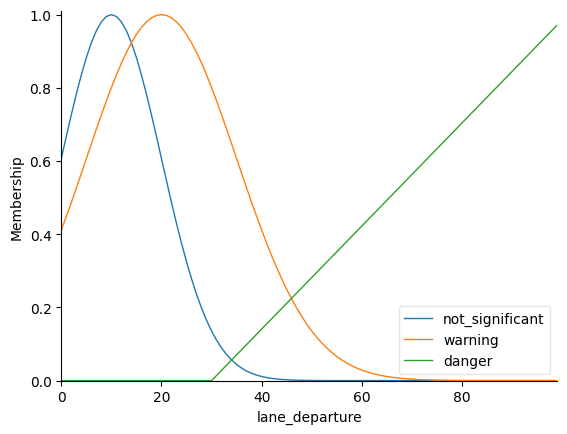

In [126]:
_ = lane_departure.view()

In [159]:
distance_to_left.automf(number=3, names=["touching", "close", "far"])
distance_to_right.automf(number=3, names=["touching", "close", "far"])

delta_left_lane.automf(number=3, names=["stop", "slow", "fast"])

In [172]:
rule1 = ctrl.Rule(distance_to_left["touching"] & distance_to_right["far"] & (delta_left_lane["slow"] | delta_left_lane["fast"]), lane_departure["danger"])
rule2 = ctrl.Rule(distance_to_left["far"] & distance_to_right["touching"] & (delta_left_lane["slow"] | delta_left_lane["fast"]), lane_departure["danger"])

rule3 = ctrl.Rule(distance_to_left["touching"] & distance_to_right["close"]  & (delta_left_lane["slow"] | delta_left_lane["fast"]), lane_departure["danger"])
rule4 = ctrl.Rule(distance_to_left["close"] & distance_to_right["touching"]  & (delta_left_lane["slow"] | delta_left_lane["fast"]), lane_departure["danger"])

rule5 = ctrl.Rule(distance_to_left["close"] & distance_to_right["far"], lane_departure["warning"])
rule6 = ctrl.Rule(distance_to_left["far"] & distance_to_right["close"], lane_departure["warning"])

rule7 = ctrl.Rule(distance_to_left["close"] & distance_to_right["close"], lane_departure["not_significant"])
rule8 = ctrl.Rule(distance_to_left["far"] & distance_to_right["far"], lane_departure["not_significant"])
rule9 = ctrl.Rule(distance_to_left["touching"] & distance_to_right["touching"], lane_departure["not_significant"])




# rule9 = ctrl.Rule(delta_left_lane["stop"], lane_departure["not_significant"])
# rule10 = ctrl.Rule(delta_left_lane["slow"], lane_departure["warning"])
# rule11 = ctrl.Rule(delta_left_lane["fast"], lane_departure["danger"])


# rule3 = ctrl.Rule(distance_to_left["touching"] | distance_to_right["touching"], lane_departure["danger"])

# rule4 = ctrl.Rule(distance_to_left["close"] & distance_to_right["far"], lane_departure["warning"])
# rule5 = ctrl.Rule(distance_to_left["close"] & distance_to_right["close"], lane_departure["warning"])

# rule6 = ctrl.Rule(distance_to_left["far"] & distance_to_right["close"], lane_departure["warning"])
# rule7 = ctrl.Rule(distance_to_left["far"] & distance_to_right["far"], lane_departure["not_significant"])

In [173]:
# rule1 = ctrl.Rule(distance_to_left["touching"] & distance_to_right["far"], lane_departure["danger"])
# rule2 = ctrl.Rule(distance_to_left["far"] & distance_to_right["touching"], lane_departure["danger"])
# rule3 = ctrl.Rule(distance_to_left["touching"] | distance_to_right["touching"], lane_departure["danger"])

# rule4 = ctrl.Rule(distance_to_left["close"] & distance_to_right["far"], lane_departure["warning"])
# rule5 = ctrl.Rule(distance_to_left["close"] & distance_to_right["close"], lane_departure["warning"])

# rule6 = ctrl.Rule(distance_to_left["far"] & distance_to_right["close"], lane_departure["warning"])
# rule7 = ctrl.Rule(distance_to_left["far"] & distance_to_right["far"], lane_departure["not_significant"])

In [174]:
lane_crossing_detector =ctrl.ControlSystem([
    rule1, rule2, rule3, 
    rule4, rule5, rule6, 
    rule7, rule8, rule9
    ])

crossing = ctrl.ControlSystemSimulation(lane_crossing_detector)

# TEST ON INPUT DATA

In [175]:
import pandas as pd
data_csv_path = R"C:\Users\akuzansk\OneDrive - Hexagon\Desktop\Praca\magisterska\inputData\training\wanted_lane_departure\1.csv"
csv_data = pd.read_csv(data_csv_path)

In [176]:
for row in csv_data.itertuples():
    state = getattr(row, 'state')
    dist_left = getattr(row, 'distance_to_left')
    dist_right = getattr(row, 'distance_to_right')
    delta_left = getattr(row, 'delta_left_lane')


    # print(state, distance_to_left, distance_to_right)

    crossing.input['distance_left'] = dist_left
    crossing.input['distance_right'] = dist_right
    crossing.input['delta_left_lane'] = delta_left


    crossing.compute()
    print(crossing.output['lane_departure'])

23.35490302999754
23.344054243879054
23.347535123669356
23.373884627665753
23.39639371681317
23.402030416049794
23.42855992824109
23.42240909506313
23.42876202192345
23.47169300647087
23.494859762194437
23.558572646489054
23.577127969676976
23.58345519752453
23.580109438187762
23.541235051762456
23.53103559916057
23.489503486414247
23.47555641105347
23.462493179467838
23.44137558562107
23.459913176105246
23.471633794144413
23.48814462582281
23.518157910690203
23.52568054695778
23.50690784869084
23.502883654977417
23.51314829708611
23.54519690364409
23.572418628205863
23.581605885595966
23.576578207932332
23.570771769808584
23.583108542071965
23.595311433227447
23.597920160326613
23.57675556495496
23.544727968645716
23.50965327901787
23.471431616170626
23.433094209385626
23.386163077248657
23.35156251312715
23.310093859540412
23.28311875612842
23.271305237032834
23.269238081779662
23.26382911127968
23.25924520394875
23.26658738969402
23.24317344157073
23.24627971990686
23.25258537159609

c:\virtual_envs\mgr\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


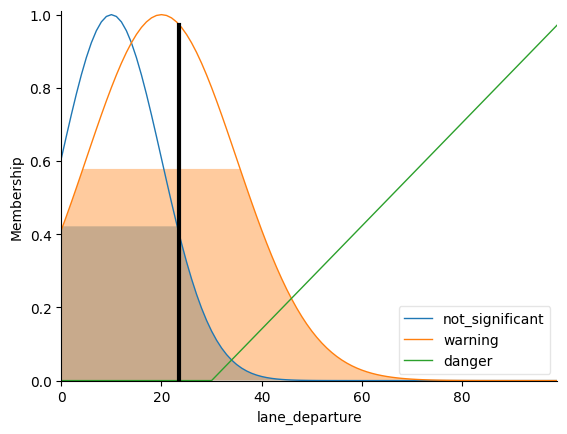

In [165]:
lane_departure.view(sim=crossing)